In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.losses import MeanSquaredError
import pickle
import json
import matplotlib.pyplot as plt


In [6]:
# Load the training data
df = pd.read_csv("train_data.csv")

# Drop unnecessary columns
df_numeric = df.select_dtypes(exclude=['object'])
column_to_drop = 'datasetId'
df.drop(column_to_drop, axis=1, inplace=True)

In [7]:
# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()

In [8]:
# Select the target variable 'HR'
target_column = 'HR'

# Specify the columns to scale
columns_to_scale = ['MEAN_RR', 'MEDIAN_RR', 'LF_NU', 'HF_NU', 'HF_LF', 'SDRR_RMSSD_REL_RR', 'HF_PCT', 'HF', 'SDSD_REL_RR', 'RMSSD_REL_RR', 'higuci', 'LF_HF', 'VLF', 'TP', 'sampen', 'SKEW', 'SKEW_REL_RR']

# Standard Scaling
standard_scaler = MinMaxScaler()
df_numeric[columns_to_scale] = standard_scaler.fit_transform(df_numeric[columns_to_scale])


In [9]:
# Specify features (X) and target variable (y)
X = df_numeric[columns_to_scale]
y = df_numeric['HR']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss=MeanSquaredError())

# Train the model
history = model.fit(X_train, y_train, epochs=128, batch_size=64, verbose=1, validation_data=(X_test, y_test))


Epoch 1/128
63/63 [==============================] - 2s 14ms/step - loss: 4923.1821 - val_loss: 4031.4202
Epoch 2/128
63/63 [==============================] - 0s 8ms/step - loss: 3806.4775 - val_loss: 3425.8420
Epoch 3/128
63/63 [==============================] - 0s 8ms/step - loss: 3318.5691 - val_loss: 3020.8994
Epoch 4/128
63/63 [==============================] - 0s 8ms/step - loss: 2945.1040 - val_loss: 2682.9250
Epoch 5/128
63/63 [==============================] - 1s 8ms/step - loss: 2622.2717 - val_loss: 2384.6956
Epoch 6/128
63/63 [==============================] - 1s 9ms/step - loss: 2334.9744 - val_loss: 2118.4099
Epoch 7/128
63/63 [==============================] - 1s 9ms/step - loss: 2077.1389 - val_loss: 1878.2126
Epoch 8/128
63/63 [==============================] - 1s 9ms/step - loss: 1845.0153 - val_loss: 1662.7961
Epoch 9/128
63/63 [==============================] - 1s 9ms/step - loss: 1635.6635 - val_loss: 1469.3434
Epoch 10/128
63/63 [==============================] - 

In [11]:
# Save the trained model
model.save('model.h5')

# Serialize the model using pickle (optional)
model_bytes = pickle.dumps(model)

# Save the serialized model to a JSON file (optional)
with open('model.json', 'w') as json_file:
    json.dump({'model': model_bytes.decode('latin-1')}, json_file)

# Save the scaler parameters
scaler_params = {'min_': standard_scaler.min_, 'scale_': standard_scaler.scale_}
with open('scaler_params.pkl', 'wb') as scaler_file:
    pickle.dump(scaler_params, scaler_file)


INFO:tensorflow:Assets written to: ram://d0189acc-9138-47fb-8f81-d27ec0c897f8/assets


INFO:tensorflow:Assets written to: ram://d0189acc-9138-47fb-8f81-d27ec0c897f8/assets


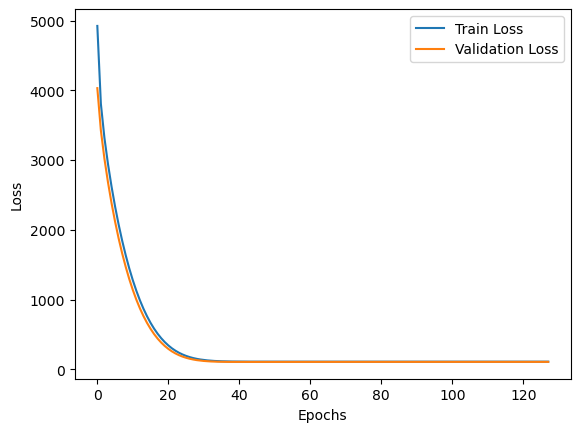

In [12]:
# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:

# Predict on the training data
predictions_train = model.predict(X_train)
# Print the first few predictions on training data
print("Predictions on Training Data:")
print(predictions_train[:5])

125/125 [==============================] - 1s 3ms/step
Predictions on Training Data:
[[74.24259 ]
 [74.24297 ]
 [74.24236 ]
 [74.24247 ]
 [74.242485]]


In [14]:
from sklearn.metrics import mean_squared_error

# Predict on the training data
predictions_train = model.predict(X_train)

# Predict on the test data
predictions_test = model.predict(X_test)

# Calculate RMSE for training data
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))

# Calculate RMSE for test data
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))

print(f"RMSE for Training Data: {rmse_train}")
print(f"RMSE for Test Data: {rmse_test}")


32/32 [==============================] - 0s 3ms/step
RMSE for Training Data: 10.55472146735945
RMSE for Test Data: 10.413237132307415
